In [1]:
#Imports
import numpy as np
from astropy.table import Table
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d 
import os
import time
from tqdm import tqdm
import specutils.analysis
from specutils import Spectrum1D
import astropy.units as u
from astropy.nddata import StdDevUncertainty
from specutils.analysis import template_comparison
from specutils.analysis import correlation

%matplotlib inline

In [2]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"

tmplt_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data_path = os.path.join(dataset_dir,"retry_updated.fits")

spec_data = Table.read(spec_data_path)
tmplt_data = Table.read(tmplt_data_path)

In [3]:
observed_specs = np.array(spec_data["spec_norm"])
observed_wavelengths = np.linspace(3570,5440,len(observed_specs[0]))

norm_tmplt_specs = np.array(tmplt_data["norm_specs"])

In [4]:
def chi_sq(observed_spectra,norm_tmplt_specs,err):
    min_score = np.inf
    min_idx = None
    scores = []
    for i,norm_tmplt in enumerate(norm_tmplt_specs):
        numerator = (observed_spectra-norm_tmplt)**2
        denominator = np.sqrt(1/err)
        chi_sq_score = np.sum(numerator/denominator)
        scores.append(chi_sq_score)
        if chi_sq_score < min_score:
            min_score = chi_sq_score
            min_idx = i
    
    return min_idx

min_score_idx = []
counter = 0

for observed_spec in tqdm(observed_specs):
    err = np.array(spec_data["updated_var"][counter])
    idx = chi_sq(observed_spec,norm_tmplt_specs,err)
    min_score_idx.append(idx)
    counter += 1

min_score_idx = np.array(min_score_idx)
len(set(min_score_idx))

#plot of chi sq dist
#plot the spectra (w/error) and max/min chi2 template


100%|██████████| 1391/1391 [00:15<00:00, 88.30it/s]


177

In [5]:
observed_wavelengths = observed_wavelengths * u.m
norm_tmplt_specs = norm_tmplt_specs * u.Jy
observed_specs = observed_specs * u.Jy

In [63]:
lags =  []
for obs_idx in tqdm(range(1391)):
    best_fit_idx = min_score_idx[obs_idx]
    obs = Spectrum1D(spectral_axis=observed_wavelengths, flux=observed_specs[obs_idx], uncertainty=StdDevUncertainty(spec_data["updated_var"][0]),unit="Jy")
    tmpl = Spectrum1D(spectral_axis=observed_wavelengths,flux=norm_tmplt_specs[best_fit_idx],unit="Jy")
    corr, lag = correlation.template_correlate(obs,tmpl)
    
    lags.append(float(lag[np.argmax(corr)] * u.s * (1/u.km)))

  0%|          | 0/1391 [00:00<?, ?it/s]c:\Users\nachi\anaconda3\Lib\site-packages\astropy\units\quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 1391/1391 [00:33<00:00, 42.05it/s]


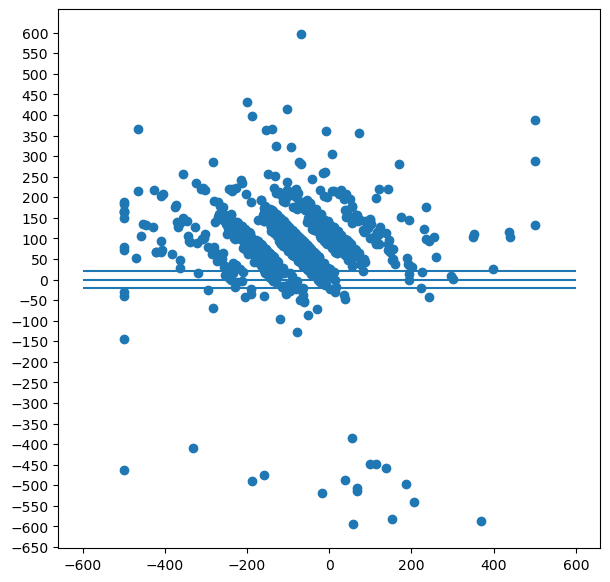

In [65]:
total = 1391
delta_RV =  np.array(lags) + np.array(spec_data["barycor"][:total]/1000) - spec_data["RV_1"][:total]
skips = np.where((delta_RV < 600) & (delta_RV > -600))

plt.figure(figsize=(7,7))
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
plt.scatter(spec_data["RV_1"][skips],delta_RV[skips])

In [6]:
spec_tmplts = []
counter = 0
for tmplt in tmplt_data["og_norm"]:
    tmp_r = Spectrum1D(spectral_axis=tmplt_data["wavelengths"][counter] * u.m, flux=tmplt * u.Jy, unit="Jy")
    spec_tmplts.append(tmp_r)
    counter += 1

In [7]:
rs_values = np.arange(-600, 600+1, 1)
tm_result = template_comparison.template_match(observed_spectrum=obs, spectral_templates=spec_tmplts, resample_method="spline_interpolated") 

In [8]:
tm_result

(<Spectrum1D(flux=<Quantity [0.38127265, 0.39410245, 0.40664312, ..., 0.510409  , 0.49824061,
            0.48605289] Jy>, spectral_axis=<SpectralAxis [3470. , 3470.1, 3470.2, ..., 5539.8, 5539.9, 5540. ] m>)>,
 None,
 237,
 20.773932333897804,
 [])

In [ ]:
chi_tmplts = []
spec_obs = []
counter = 0
for spectrum in tqdm(observed_specs[:500]):
    obs = Spectrum1D(spectral_axis=observed_wavelengths, flux=spectrum, uncertainty=StdDevUncertainty(spec_data["updated_var"][counter]),unit="Jy")
    tm_result = template_comparison.template_match(observed_spectrum=obs, spectral_templates=spec_tmplts, resample_method="spline_interpolated") 
    chi_tmplts.append(tm_result[0])
    spec_obs.append(obs)


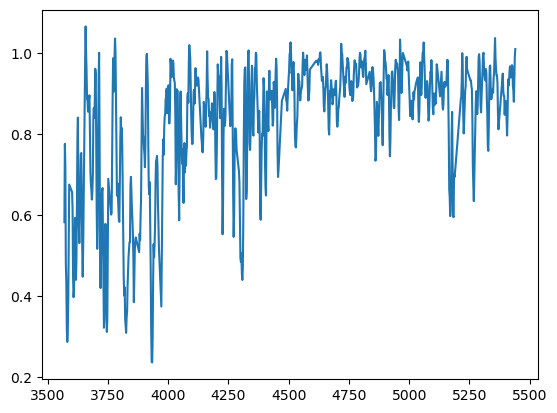

In [12]:
plt.plot(obs.spectral_axis,obs.flux)

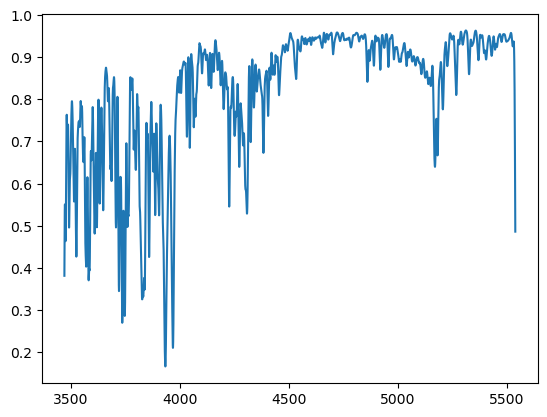

In [13]:
plt.plot(tm_result[0].spectral_axis,tm_result[0].flux)

In [ ]:
tm_result[0].spectral_axis